# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [1]:
!pip install livelossplot

In [46]:
import pandas as pd
import string
import nltk 
from gensim.models import Word2Vec
import re
import torch
import numpy as np
from livelossplot import PlotLosses
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
pd.set_option('display.width', -1)
pd.set_option('max_colwidth', -1)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier,XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report

stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def plt_confusion_matrix(cm, class_names, normalize =False):
  
  if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      
  
  df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                    columns = class_names)
  
  plt.figure(figsize = (20,14))
  sns.heatmap(df_cm, annot=True)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
lyrics_df = pd.read_csv("/content/drive/My Drive/lyrics.csv", usecols=['genre', 'lyrics'])
lyrics_df.sample(2)

,genre,lyrics
352303,Rock,"E-d-see-bb e-d-see-bb e-d-see-bb e-d-see-bb\nE-g-see-a\nE someone please g save us\nSee save us from our a wicked little selves\nE we're bent or cour-g-ageous\nSee we're drifting so it's a hard for me to tell\nI want to make you mine all of the time\nI want to be your ? man\nGet outta my head or into my bed.\nGet outta my head or into my bed.\nEi d had a see dream about bb you last e night d-see-bb\nEi d had a see dream about bb you last e night d-see-bb\nYeah we were contageous\nWe were both covered up with bees\nI felt so outrageous\nThe hip priest man, he ain't got nothing on me\nI want to make you mine all of the time\nI want to be your ? man\nGet outta my head or into my bed.\nGet outta my head or into my bed.\nI had a dream about you last night\nI had a dream about you last night"
83542,Rock,"Deep down this boy can feel too much\nHis flesh is weak he needs the satin crown\nGot balls intact despite the fact\nHe'll curse his luck, his painful guts\nScrewed up the path he followed\nAlways the pretty songs for us to sing along and bust up\nThis is the worst news I have heard alone and disturbed now\nHe's divine this time\nWhen will you listen?\nNo fake what does it take when will you listen\nWhen will you learn?\nYou fuss you fight I don't think it's right\nThat you pushed this man so deep down this hole\nCome back\nCome back\nAlways the pretty songs for us to sing along and get fucked up"


In [0]:
lyrics_df = lyrics_df.where((pd.notnull(lyrics_df)), None)

In [6]:
lyrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362237 entries, 0 to 362236
Data columns (total 2 columns):
genre     362237 non-null object
lyrics    266557 non-null object
dtypes: object(2)
memory usage: 5.5+ MB


In [0]:
lyrics_df = lyrics_df[lyrics_df['lyrics'].notnull()]

In [0]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [0]:
def cleanText(text):
  text = text.lower()
  text = re.sub(r'\d', '#', text) 
  text = re.sub(r"\s+"," ", text, flags = re.I)
  tokens = tokenizer.tokenize(text.lower())
  tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
  
  return tokens if len(tokens) > 0 else None

In [0]:
lyrics_df['clean_lyrics'] = lyrics_df['lyrics'].apply(cleanText)

In [0]:
lyrics_df = lyrics_df[lyrics_df['clean_lyrics'].notnull()]

In [14]:
lyrics_df[['genre', 'clean_lyrics']].sample(3)

,genre,clean_lyrics
233006,R&B,"[written, jon, john, babyface, r, phillips, performed, diana, ross, wanna, know, style, kinda, style, makes, woman, wanna, lose, mind, wanna, know, make, worth, time, like, rest, give, best, fall, behind, cause, wanna, know, turns, keep, lovin, strong, cause, ask, cause, roni, give, need, think, could, swing, little, time, swing, need, think, could, swing, little, time, swing, need, thing, find, man, gives, love, kind, cool, takie, night, candlelight, want, one, never, cause, wanna, know, turns, keep, lovin, strong, cause, ask, cause, roni, give, need, hook, times, cause, wanna, know, turns, keep, lovin, strong, cause, ask, cause, roni, give, need, swing, swing, ...]"
43779,Rock,"[travel, searching, home, found, stopping, goin, hunting, hunter, bring, back, goods, know, thought, could, organize, freedom, american, figured, could, smell, left, complete, mission, leaving, behind, going, hunting, hunter, hunter, hunter, know, know, know, know, know, know, know]"
148392,Rock,[instrumental]


In [0]:
FEATURE_VECTOR_SIZE = 300 
WINDOW_SIZE = 5
all_sentenses = lyrics_df["clean_lyrics"].tolist()
wevec_model = Word2Vec(all_sentenses, size=FEATURE_VECTOR_SIZE, window=WINDOW_SIZE, workers=4, min_count=3)

### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [0]:
for word in ['love', 'man', 'girl', 'feel']:
  print('**********{}**************'.format(word))
  print(wevec_model.wv.most_similar('love'))
  print('**********{}**************'.format(word))
  

**********love**************
[('know', 0.6976536512374878), ('baby', 0.6739638447761536), ('cause', 0.6532072424888611), ('true', 0.620837926864624), ('oh', 0.6157742738723755), ('want', 0.6149493455886841), ('never', 0.6118445992469788), ('always', 0.6080036163330078), ('heart', 0.6009585857391357), ('way', 0.5991636514663696)]
**********love**************
**********man**************
[('know', 0.6976536512374878), ('baby', 0.6739638447761536), ('cause', 0.6532072424888611), ('true', 0.620837926864624), ('oh', 0.6157742738723755), ('want', 0.6149493455886841), ('never', 0.6118445992469788), ('always', 0.6080036163330078), ('heart', 0.6009585857391357), ('way', 0.5991636514663696)]
**********man**************
**********girl**************
[('know', 0.6976536512374878), ('baby', 0.6739638447761536), ('cause', 0.6532072424888611), ('true', 0.620837926864624), ('oh', 0.6157742738723755), ('want', 0.6149493455886841), ('never', 0.6118445992469788), ('always', 0.6080036163330078), ('heart', 0

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [0]:
v1 = wevec_model.wv['king'] 
v2 = wevec_model.wv['queen'] 

res =  v1 - v2 
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('king', 0.4416906237602234),
 ('victorious', 0.28422659635543823),
 ('christ', 0.28422001004219055),
 ('overthrow', 0.2781832814216614),
 ('disarmament', 0.2606436610221863),
 ('undisputed', 0.2583610415458679),
 ('overcome', 0.25667399168014526),
 ('solomon', 0.2539622485637665),
 ('dispear', 0.24596869945526123),
 ('battle', 0.23669087886810303)]

In [0]:
v1 = wevec_model.wv['woman'] 
v2 = wevec_model.wv['girl'] 

res =  v1 - v2 
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('woman', 0.3945504426956177),
 ('witchy', 0.3829672932624817),
 ('adherence', 0.3591882586479187),
 ('hath', 0.355106920003891),
 ('wastelands', 0.35092365741729736),
 ('hinguckt', 0.3403870761394501),
 ('wanhopige', 0.3390408158302307),
 ('incarnate', 0.33836591243743896),
 ('parachutist', 0.3364051580429077),
 ('dissatisfied', 0.3338039517402649)]

In [0]:
v1 = wevec_model.wv['girl'] 
v2 = wevec_model.wv['man'] 

res =  v1 + v2 
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('girl', 0.8658943176269531),
 ('man', 0.8452440500259399),
 ('woman', 0.7247971892356873),
 ('boy', 0.7180936336517334),
 ('know', 0.6527124047279358),
 ('baby', 0.6476815938949585),
 ('cause', 0.638348400592804),
 ('got', 0.6022270321846008),
 ('yeah', 0.5943912267684937),
 ('love', 0.5738491415977478)]

In [0]:
v1 = wevec_model.wv['woman'] 
v2 = wevec_model.wv['husband'] 

res =  v1 + v2 
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('woman', 0.8930797576904297),
 ('husband', 0.7790439128875732),
 ('wife', 0.6306020021438599),
 ('man', 0.6067594289779663),
 ('girl', 0.5493606328964233),
 ('daughter', 0.5384731292724609),
 ('child', 0.49661391973495483),
 ('women', 0.48693349957466125),
 ('neighbor', 0.46220311522483826),
 ('lovin', 0.4582667052745819)]

In [0]:
v1 = wevec_model.wv['wife'] 
v2 = wevec_model.wv['woman'] 

res =  v1 - v2 
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('wife', 0.5940633416175842),
 ('doorjust', 0.39944425225257874),
 ('beaters', 0.38050615787506104),
 ('tillman', 0.3772699236869812),
 ('nephews', 0.3584328591823578),
 ('ahhhhaaaaaaaaghhhh', 0.3539944887161255),
 ('attended', 0.34795355796813965),
 ('swipe', 0.33600378036499023),
 ('saver', 0.3341713845729828),
 ('burglary', 0.32993119955062866)]

In [0]:
v1 = wevec_model.wv['young'] 
v2 = wevec_model.wv['baby'] 

res =  v1 + v2 
wevec_model.wv.similar_by_vector(res)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('young', 0.7975558042526245),
 ('baby', 0.7816184163093567),
 ('girl', 0.6593176126480103),
 ('love', 0.6478465795516968),
 ('cause', 0.6436699628829956),
 ('know', 0.6418748497962952),
 ('yeah', 0.6136243343353271),
 ('boy', 0.6044150590896606),
 ('got', 0.5908496975898743),
 ('want', 0.58655846118927)]

## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [17]:
twitter_lex_df = pd.read_csv('/content/drive/My Drive/SemEval2015-English-Twitter-Lexicon.txt', sep='\t',  names =['polarity', 'word'])
twitter_lex_df.describe(include = 'all')

,polarity,word
count,1515.000000,1515
unique,NaN,1515
top,NaN,don't feel
freq,NaN,1
mean,0.000319,NaN
std,0.502247,NaN
min,-0.984000,NaN
25%,-0.422000,NaN
50%,0.031000,NaN
75%,0.406000,NaN


In [19]:
twitter_lex_df.sample(4)

,polarity,word
869,-0.094,age
328,0.469,g'nite
555,0.203,young
929,-0.156,turnovers


In [0]:
twitter_lex_df['vector'] = twitter_lex_df["word"].apply(lambda word: wevec_model.wv[word].reshape(1,-1) if word in wevec_model.wv else None)
twitter_lex_df = twitter_lex_df[twitter_lex_df.vector.notnull()]


In [0]:
  
train, test = train_test_split(twitter_lex_df, test_size=0.2, random_state=999)
X_train = train['vector'].values
y_train = train['polarity'].values
X_test = test['vector'].values
y_test = test['polarity'].values

X_train = np.concatenate(X_train).reshape(X_train.shape[0], X_train[0].shape[1])

shape = list(X_test[0].shape)
X_test = np.concatenate(X_test).reshape(X_test.shape[0],X_test[0].shape[1])

In [22]:
model = XGBRegressor()
model.fit(X_train, y_train)

[07:16:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [23]:
model.score(X_test, y_test)

0.31221742731072255

In [27]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [0]:
import torch.utils.data as utils_data
from torch.autograd import Variable

training_samples = utils_data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
data_loader = utils_data.DataLoader(training_samples, batch_size=5, shuffle=False)	

test_samples = utils_data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_data_loader = utils_data.DataLoader(test_samples, batch_size=len(X_test), shuffle=False)	
test_data_loader_1 = utils_data.DataLoader(test_samples, batch_size=1, shuffle=False)


In [29]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from sklearn.metrics import r2_score, mean_squared_error


def score(netModel, data_loader, criterion):
  
  running_loss = 0.
  calc_count =0.
  valTrue  = []
  valPredicted  = []
  
  netModel.eval()
  
  with torch.no_grad():
    for vectors, labels in data_loader:
      if use_cuda:
        vectors = vectors.cuda()
        labels = labels.cuda().float()
        
      vectors = Variable(vectors)  
      labels = Variable(labels)
      
      outputs = netModel(vectors.float())
      
      valPredicted.extend(outputs.detach().cpu().numpy().flatten())
      valTrue.extend(labels.detach().cpu().numpy().flatten())
      
      loss = criterion(outputs.flatten(), labels.flatten())
      running_loss += loss.item()
      
  return running_loss/len(valTrue), r2_score(valTrue, valPredicted), mean_squared_error(valTrue, valPredicted)


liveloss = PlotLosses()

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.hidden(x))   
        x = self.dropout2(x)
        x = self.predict(x)  
        return x

      
      
net = Net(n_feature=300, n_hidden=20, n_output=1)     
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()

if use_cuda:
  net = net.cuda()
  
# plt.ion()  

for epoch in range(1000):
  
  net.train()
  
  batchloss = 0.0
  yTrue = []
  YPredicted = []
  for batch_idx, (data, target) in enumerate(data_loader):
        
    if use_cuda:
      data = data.cuda()
      target = target.cuda()
          
          
    data, target = Variable(data).float(), Variable(target).float()
    optimizer.zero_grad()
    prediction = net(data)
    loss = loss_func(prediction.flatten(), target.flatten()) 
    
    
    YPredicted.extend(prediction.detach().cpu().numpy().flatten())
    yTrue.extend(target.detach().cpu().numpy().flatten())
        
    loss.backward() 
    optimizer.step()
    
    batchloss += loss.item()
  
  losLog = {}
  losLog['trainning_loss'] = batchloss/len(YPredicted)
  
  r2 = r2_score(yTrue, YPredicted)
  losLog['trainning_r2'] = r2
  trainningMSE = mean_squared_error(yTrue, YPredicted)
  losLog['trainning_mse'] = trainningMSE
  
  valLoss, valR2, valMSE = score(net, test_data_loader, loss_func )
  
  losLog['validation_loss'] = valLoss
  losLog['validation_r2'] = valR2
  losLog['validation_mse'] = valMSE
  liveloss.update(losLog)
  liveloss.draw()
        

KeyboardInterrupt: ignored

Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [0]:




def tsnescatterplot(model, genere_words):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    num_of_geners = len(genere_words.keys()) * 50
    arrays = np.empty((0, 300), dtype='f')
    #arrays = np.empty((0,num_of_geners)  , dtype='f')
                      
#     word_labels = [word]
    word_labels = []

#     color_list  = ['red']
    color_list_ptions = ['white',  'green', 'purple', 'black',  'blue', 'yellow', 'orange', 'red', 'olive', 
                  'pink', 'cyan', 'brown']
    

    color_list = []                  
    for index, (genere, list_names) in  enumerate(genere_words.items()):
        color = color_list_ptions[index]
        for wrd in list_names:
            wrd_vector = model.wv.__getitem__([wrd])   
            word_labels.append(wrd)
            color_list.append(color)
            arrays = np.append(arrays, wrd_vector, axis=0)
                      
         
                    
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [0]:
texts = lyrics_df["clean_lyrics"].tolist()

all_text = [item for sublist in texts for item in sublist]
req_dist = nltk.FreqDist(all_text)
words_couter = [(word, count) for (word, count) in req_dist.items()]
words_couter.sort(key=lambda tup: tup[1], reverse=True) 
top_words = words_couter[0:3000]



In [0]:
geners = lyrics_df['genre'].unique()
word_gener_counter = np.zeros(shape=(3000, len(geners)))
word_total_counter = np.zeros(len(geners))
word_index = {word: index for index, (word,counter) in enumerate(top_words)}
index_word = {index:word for index, (word,counter) in enumerate(top_words)}

genere_index = {genere: index for index, genere in enumerate(geners)}
index_genere = {index:genere  for index, genere in enumerate(geners)}

for index, row in lyrics_df.iterrows():
    genre = row['genre']
    words = row['clean_lyrics']
    
    current_genere_index = genere_index[genre]
     
    
    for word in words:
        if word in word_index:
            word_total_counter[current_genere_index] += 1
            current_word_index = word_index[word]
            word_gener_counter[current_word_index][current_genere_index]  += 1

In [0]:
ratios = word_gener_counter / word_total_counter.reshape(12)
(ratios[1, 10],word_gener_counter[1, 10]/ word_total_counter[10])

ratios_sorted = np.argsort(ratios, axis=0, kind='quicksort')
top_ineces = ratios_sorted[0:50, :]


ratios = word_gener_counter / word_total_counter.reshape(12)
(ratios[1, 10],word_gener_counter[1, 10]/ word_total_counter[10])
genget_top_words = {}
for row in top_ineces:
    for column, val in enumerate(row):
        genre = index_genere[column]
        if genre not in genget_top_words:
            genget_top_words[genre] = []
        
        word = index_word[val]
        genget_top_words[genre].append(word)
        

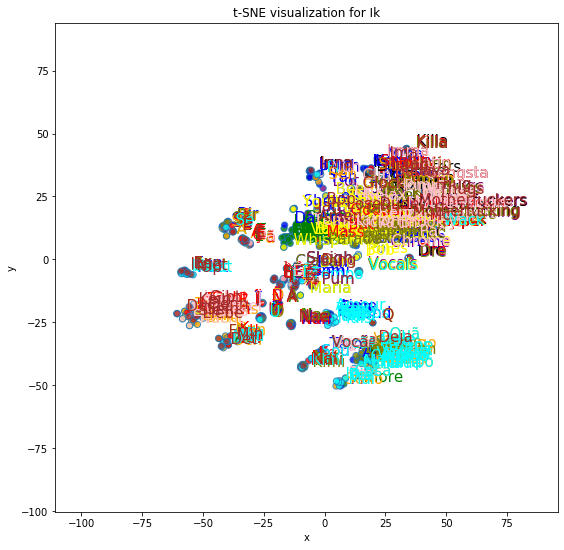

In [37]:
tsnescatterplot(wevec_model, genget_top_words)

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

In [0]:
lyrics_df['clean_sentense'] = lyrics_df['clean_lyrics'].map(lambda words: ' '.join(words)) 
train, test = train_test_split(lyrics_df, test_size=0.2, random_state=999)


X_train = train['clean_sentense'].tolist()
y_train = train['genre'].tolist()


X_test = test['clean_sentense']
y_test = test['genre']

In [0]:
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)

In [40]:
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [41]:
X_test_dtm = vect.transform(X_test)
y_pred_class = nb.predict(X_test_dtm)
accuracy = accuracy_score(y_test, y_pred_class)
accuracy


0.509929532351057

Show the confusion matrix.

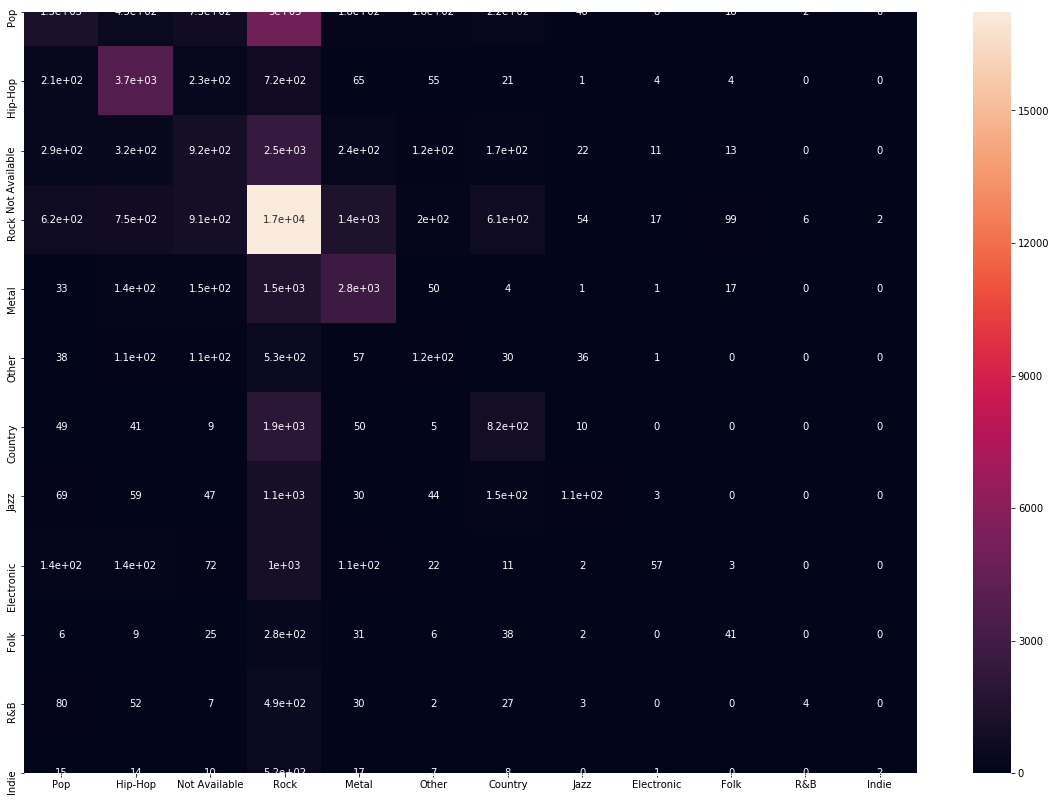

In [45]:
geners = lyrics_df['genre'].unique()
conf_mat = confusion_matrix(y_test, y_pred_class, labels = geners)
plt_confusion_matrix(conf_mat, geners)

Show the classification report - precision, recall, f1 for each class.

In [47]:
print(classification_report(y_test, y_pred_class))


               precision    recall  f1-score   support

      Country       0.39      0.28      0.33      2888
   Electronic       0.55      0.04      0.07      1581
         Folk       0.21      0.09      0.13       435
      Hip-Hop       0.64      0.74      0.69      5008
        Indie       0.50      0.00      0.01       595
         Jazz       0.38      0.07      0.12      1566
        Metal       0.56      0.59      0.58      4719
Not Available       0.28      0.20      0.24      4583
        Other       0.15      0.12      0.13      1037
          Pop       0.45      0.16      0.23      8114
          R&B       0.33      0.01      0.01       695
         Rock       0.53      0.79      0.63     21853

     accuracy                           0.51     53074
    macro avg       0.41      0.26      0.26     53074
 weighted avg       0.48      0.51      0.46     53074



[link text](https://)### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [0]:
def avg_sentense(sentense_words):
    vectors = []
    for word in sentense_words:
      if word in wevec_model.wv:
        vectors.append(wevec_model.wv[word].reshape(1,-1))
    
    if len(vectors) > 1:
        #return np.mean(vectors, axis=0)
        return np.concatenate(vectors).mean(axis=0).flatten()
        
    elif len(vectors) ==1:
        return vectors[0][0].flatten()
    else:
        return None


In [0]:
lyrics_df = lyrics_df[lyrics_df.clean_lyrics.notnull()]
lyrics_df['avg_vector'] = lyrics_df["clean_lyrics"].map(lambda sentense: (avg_sentense(sentense)))

In [82]:
lyrics_df["clean_lyrics"].sample(1).map(lambda sentense: (avg_sentense(sentense)))

289396    [-0.5018303, 0.55506, -0.055607695, 0.18106334, 0.6255077, -0.5162023, 1.0287136, 1.5346574, 0.35379058, 0.11648924, 0.39957562, 1.376006, 0.59835595, -0.4191012, -0.35221186, -0.06991421, 0.38435674, 0.70955426, -1.1908681, -0.28061524, 0.12701692, 0.3369138, 0.38385534, -0.17301916, -0.6557818, -0.5968585, 0.27325913, -0.3394589, -0.7789423, 0.38745955, -0.68865347, 0.24971454, 0.55055755, 0.44622713, 0.09521971, -0.83432865, 0.54070836, 0.4017019, -1.6859702, 0.2476546, 0.81857115, -0.1769637, -0.24311955, 0.13981824, -1.0457183, 0.33445767, -0.15838598, 0.49297008, -0.21521111, 0.2917587, -0.5116512, -0.66315776, 0.9215394, 0.44875887, -0.347298, -0.64172494, -0.04161022, -0.017646752, -0.6238763, -0.86569196, 0.4269472, 0.28925163, -0.04513591, 1.0675752, 0.31119442, 0.81247103, -0.14964531, 0.34749928, 0.54454356, -0.4930853, 0.2775732, -0.35631588, 0.5577445, -0.0931644, -0.2487093, 0.35882428, 0.106339835, -0.64089066, -0.5358259, 0.34448376, -0.14298555, -0.15740047,

In [0]:
train, test = train_test_split(lyrics_df, test_size=0.2, random_state=999)


In [0]:
X_train = train['avg_vector'].tolist()
#X_train = [x.squeeze() for x in X_train]
#X_train = np.asanyarray(X_train)

y_train = train['genre'].tolist()

X_test = test['avg_vector'].tolist()
# X_test = [x.squeeze() for x in X_test]
# X_test = np.asanyarray(X_test)

y_test = test['genre']


In [88]:

scaler = MinMaxScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)
X_test1 = scaler.transform(X_test)


ValueError: ignored

In [0]:
translator = {}
translator2 = {}
for index, y in  enumerate(set(y_train)):
    translator[index] = y
    translator2[y] = index

In [87]:
nb = MultinomialNB()
nb.fit(X_scaled, y_train_numbers)

NameError: ignored

In [0]:
y_train_numbers = [translator2[y] for y in y_train]

In [61]:
train.sample(10)

,genre,lyrics,clean_lyrics,clean_sentense,avg_vector
75052,Not Available,"Candle light and chocolate kisses\nCalls to say you missed me when we started\nGerald:\nYour nails was done, your hair was pressed\nI miss the way you used to dress\nWhen I met you\nI really do\nKelly:\nI gave my best 4 years, my time was wasted\nGerald:\nSee I shared your fears, and the tears you cried I tasted\nKelly:\nBaby, I loved your kids, opened up my home. Yes I did\nGerald:\nPaid your mama's bills. Gave you all when\nyou had nothing.\nChorus\nLove you so, can't let go.\nNever thought I'd be without you\nCan't imagine life without you\nwalk away, everyday.\nTold me that you'd never leave.\nBut now you say it hurts too much to stay.\nKelly:\nToo much to stay\nGerald:\nSaid it's hard for me\nYour lover's stayin with his mom\nTell me was it worth the drama oh baby\nSee we got our own kids yeah\nKelly:\nIf there had to be another.\nWhy go trick'n in the gutter\nAnd drivin our sh.... mmmmmm\nboo baby\nGerald:\nSee I know he can't put that thang down like I do.\nKelly:\nBaby that was the past. You don't roll like you used\nGerald:\nSaid what's my motivation\nGirl I'm better off alone.\nKelly:\nTell me why can't we just walk away.\nGerald and Kelly:\nWhy are we so torn?\nChorus\nBoth:\nNever meant to hurt you.\nG: you walk away from me\ntell me why did you change\nKelly:\nCan't it be all that we have hoped and prayed for\nnow its gone away\nGerald:\nOh baby, everything. Our hopes and dreams they are\nno longer. We can't go back the way it used to be\nsaid now really.\nChorus\nGerald:\nTryin to make you understand that I only just a man\nKelly:\nGoing to jail cause I kill yo girl\nGoing to jail cause I kill yo girl\nGerald:\nCome on now don't do this now\ncome on now don't do this now\nKelly:\nYour body belongs to me\nShe can't have you no matter what she thinks\nNo no no no no no no no no","[candle, light, chocolate, kisses, calls, say, missed, started, gerald, nails, done, hair, pressed, miss, way, used, dress, met, really, kelly, gave, best, years, time, wasted, gerald, see, shared, fears, tears, cried, tasted, kelly, baby, loved, kids, opened, home, yes, gerald, paid, mama, bills, gave, nothing, chorus, love, let, go, never, thought, without, imagine, life, without, walk, away, everyday, told, never, leave, say, hurts, much, stay, kelly, much, stay, gerald, said, hard, lover, stayin, mom, tell, worth, drama, oh, baby, see, got, kids, yeah, kelly, another, go, trick, n, gutter, drivin, sh, mmmmmm, boo, baby, gerald, see, know, put, thang, like, ...]",candle light chocolate kisses calls say missed started gerald nails done hair pressed miss way used dress met really kelly gave best years time wasted gerald see shared fears tears cried tasted kelly baby loved kids opened home yes gerald paid mama bills gave nothing chorus love let go never thought without imagine life without walk away everyday told never leave say hurts much stay kelly much stay gerald said hard lover stayin mom tell worth drama oh baby see got kids yeah kelly another go trick n gutter drivin sh mmmmmm boo baby gerald see know put thang like kelly baby past roll like used gerald said motivation girl better alone kelly tell walk away gerald kelly torn chorus never meant hurt g walk away tell change kelly hoped prayed gone away gerald oh baby everything hopes dreams longer go back way used said really chorus gerald tryin make understand man kelly going jail cause kill yo girl going jail cause kill yo girl gerald come come kelly body belongs matter thinks,"[-0.22532901, 0.424555, 0.22073254, 0.12915924, 0.7011071, -0.3741459, 0.7637562, 0.92419267, 0.39707303, 0.07572546, 0.49225128, 0.9475905, 0.61015683, -0.45786718, -0.5193757, -0.16280635, 0.23117271, 0.44702598, -0.81277746, -0.17867742, 0.24962763, 0.2361407, 0.12101826, -0.092190266, -0.44787735, -0.33349103, 0.31659085, -0.16030036, -0.46242744, -0.08145312, -0.5198053, 0.019894991, 0.6621323, 0.44839695, -0.15070549, -0.6019854, 

In [59]:
scaler = MinMaxScaler()
scaler.fit(X_train)

ValueError: ignored

In [57]:
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_scaled = scaler.transform(X_train)
# X_test1 = scaler.transform(X_test)

ValueError: ignored

#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.